# Railway track crack detection

## Load Dataset and Display Samples

C:\Users\moune\anaconda3\envs\ML\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


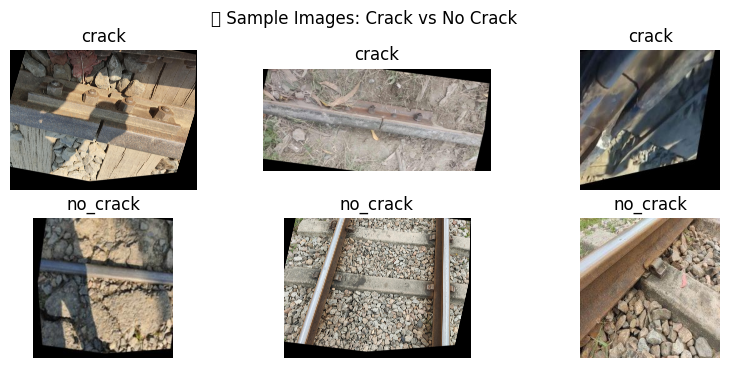

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import random

# Dataset path
data_dir = "dataset_byy_class"
classes = ["crack", "no_crack"]

# Show 3 random images from each class
plt.figure(figsize=(10, 4))
for i, cls in enumerate(classes):
    folder = os.path.join(data_dir, cls)
    sample_imgs = random.sample(os.listdir(folder), 3)
    for j, img_name in enumerate(sample_imgs):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(2, 3, i*3 + j + 1)
        plt.imshow(img)
        plt.title(cls)
        plt.axis("off")
plt.suptitle("🔍 Sample Images: Crack vs No Crack")
plt.show()


##  Preprocessing
*grayscale(Converts all to grayscale — cracks are texture features, not color-based.), resize them, and normalize pixel values.*

In [3]:
import numpy as np

image_size = (128, 128)

X, y = [], []

for label, cls in enumerate(classes):
    folder = os.path.join(data_dir, cls)
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, image_size)
        img = img / 255.0  # Normalize
        X.append(img)
        y.append(label)

X = np.array(X)
y = np.array(y)

print("✅ Preprocessing complete:", X.shape, "images loaded.")


✅ Preprocessing complete: (1869, 128, 128) images loaded.


## Feature Extraction
*HOG detects edges and shapes — perfect for identifying crack lines*

In [7]:
from skimage.feature import hog

features = []
for img in X:
    f, _ = hog(img, orientations=9, pixels_per_cell=(8,8),
               cells_per_block=(2,2), block_norm='L2-Hys',
               visualize=True, feature_vector=True)
    features.append(f)

X_features = np.array(features)
print("✅ HOG feature extraction complete:", X_features.shape)


✅ HOG feature extraction complete: (1869, 8100)


## Train-Test Split
*80% data for training, 20% for testing.*

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_features, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")


Train: 1495, Test: 374


## Train 3 Classical ML Models

In [9]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

models = {
    "SVM": SVC(kernel='linear'),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000)
}

results = {}

for name, model in models.items():
    print(f"\n🔧 Training {name}...")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f"✅ {name} Accuracy: {acc*100:.2f}%")
    print(classification_report(y_test, preds, target_names=classes))
    results[name] = acc



🔧 Training SVM...
✅ SVM Accuracy: 67.11%
              precision    recall  f1-score   support

       crack       0.78      0.76      0.77       267
    no_crack       0.43      0.46      0.44       107

    accuracy                           0.67       374
   macro avg       0.60      0.61      0.61       374
weighted avg       0.68      0.67      0.67       374


🔧 Training RandomForest...
✅ RandomForest Accuracy: 73.53%
              precision    recall  f1-score   support

       crack       0.74      0.97      0.84       267
    no_crack       0.68      0.14      0.23       107

    accuracy                           0.74       374
   macro avg       0.71      0.56      0.54       374
weighted avg       0.72      0.74      0.67       374


🔧 Training LogisticRegression...
✅ LogisticRegression Accuracy: 70.32%
              precision    recall  f1-score   support

       crack       0.78      0.81      0.80       267
    no_crack       0.48      0.43      0.45       107

    accu

## Compare Models

In [10]:

best_model = max(results, key=results.get)

print("\n📊 Accuracy Comparison:")
for k, v in results.items():
    print(f"{k}: {v*100:.2f}%")

print(f"\n🏆 Best Model: {best_model} with accuracy {results[best_model]*100:.2f}%")



📊 Accuracy Comparison:
SVM: 67.11%
RandomForest: 73.53%
LogisticRegression: 70.32%

🏆 Best Model: RandomForest with accuracy 73.53%


In [36]:
resLR = models['LogisticRegression']
resSVM = models['SVM']
resRF = models['RandomForest']

In [37]:
joblib.dump(resLR, "best_crack_model_LR.pkl")
print("💾 Model saved as best_crack_modelLR.pkl")

💾 Model saved as best_crack_modelLR.pkl


In [38]:
joblib.dump(resSVM, "best_crack_model_SVM.pkl")
print("💾 Model saved as best_crack_modelSVM.pkl")

💾 Model saved as best_crack_modelSVM.pkl


In [39]:
joblib.dump(resRF, "best_crack_model_RF.pkl")
print("💾 Model saved as best_crack_modelRF.pkl")

💾 Model saved as best_crack_modelRF.pkl


In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

params = {
    'C': [0.1, 1, 5, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 0.01, 0.001]
}

grid = GridSearchCV(SVC(), params, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
print("Best Accuracy:", grid.best_score_)


Best Params: {'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}
Best Accuracy: 0.779933110367893


In [19]:
joblib.dump(grid, "best_grid_crack_model.pkl")
print("💾 Model saved as best_grid_crack_model.pkl")

💾 Model saved as best_grid_crack_model.pkl


In [25]:
# ================================
# 1️⃣ Load your saved model
# ================================
import joblib

model_path = "best_crack_model.pkl"   # Path to your saved model
print("🔄 Loading trained model...")

# ✅ LOAD the actual model object
model = joblib.load(model_path)

print("✅ Model loaded successfully!")


🔄 Loading trained model...
✅ Model loaded successfully!


In [26]:
print(type(model))


<class 'str'>
